# 당뇨병 데이터로 Feature Selection, Wrapper Method, 이상치 탐지 진행하기

In [13]:
import pandas as pd
import numpy as np

# 시각화(옵션)
import matplotlib.pyplot as plt
import seaborn as sns

# 필터/래퍼/임베디드
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# CSV 로드
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# 학습/타깃/테스트 분리
X_train = train.drop(["ID", "Outcome"], axis=1)
y_train = train["Outcome"]
X_test  = test.drop(["ID"], axis=1)

X_train.shape, y_train.shape, X_test.shape


((652, 8), (652,), (116, 8))

### Filter Method

#### 상관계수

In [14]:
# Outcome과의 상관계수
corr = X_train.corrwith(y_train).sort_values(ascending=False)
corr

Glucose                     0.460108
BMI                         0.294390
Age                         0.218183
Pregnancies                 0.211340
DiabetesPedigreeFunction    0.173584
Insulin                     0.123246
SkinThickness               0.052094
BloodPressure               0.049459
dtype: float64

In [ ]:
'''
Glucose                     0.460108
BMI                         0.294390
Age                         0.218183
Pregnancies                 0.211340
DiabetesPedigreeFunction    0.173584
Insulin                     0.123246
SkinThickness               0.052094
BloodPressure               0.049459
'''

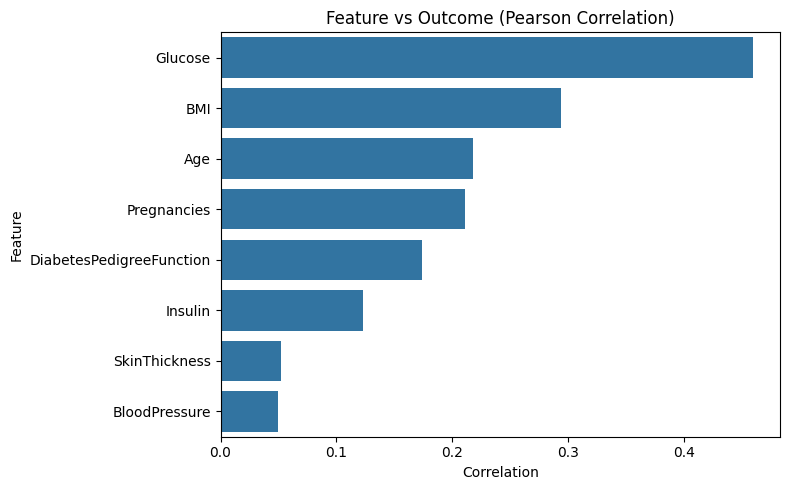

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Feature vs Outcome (Pearson Correlation)")
plt.xlabel("Correlation"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

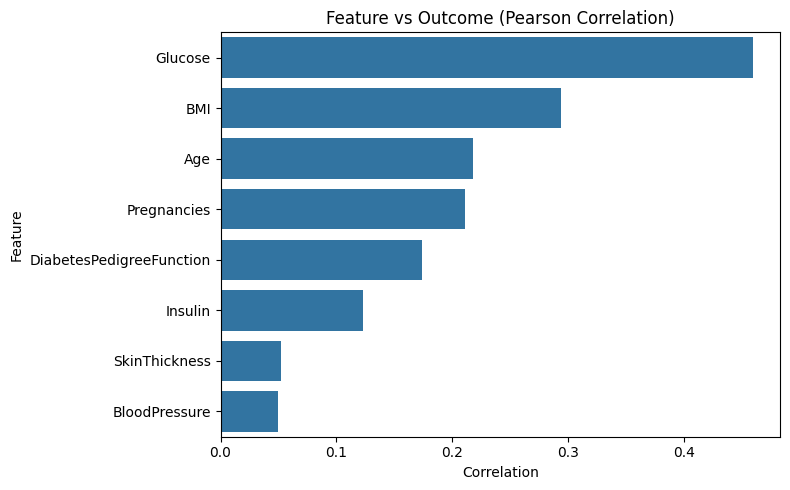

Glucose, BMI, Age 가 최상단

#### ANOVA F-Statisti

연속형 피처로 범주형 target을 얼마나 잘 구분하는지

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# SelectKBest : 가장 유용한 피처만 선택하는 클래스
# f_classif   : ANOVA F-통계량을 계산하는 함수 (분류문제용)

f_selector = SelectKBest(score_func=f_classif, k="all")
f_selector.fit(X_train, y_train)

# 각 피처의 F값 저장
f_scores = pd.Series(f_selector.scores_, index=X_train.columns).sort_values(ascending=False)
f_scores


Glucose                     174.558885
BMI                          61.677839
Age                          32.488992
Pregnancies                  30.389360
DiabetesPedigreeFunction     20.193870
Insulin                      10.025489
SkinThickness                 1.768762
BloodPressure                 1.593915
dtype: float64

In [ ]:
'''
각 피처의 F 통계량. 값이 클수록 Outcome을 잘 구분하는 피처

Glucose                     174.558885
BMI                          61.677839
Age                          32.488992
Pregnancies                  30.389360
DiabetesPedigreeFunction     20.193870
Insulin                      10.025489
SkinThickness                 1.768762
BloodPressure                 1.593915

역시 Glucose, BMI, Age가 가장 높다.

'''

### Wrapper Method

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# 2-1) RFE는 내부적으로 계수 기반 중요도를 보므로, 입력은 스케일 정규화 버전을 사용
scaler_for_rfe = StandardScaler().fit(X_train)
X_train_scaled_for_rfe = scaler_for_rfe.transform(X_train)

# 2-2) 로지스틱 회귀로 RFE 수행 (상위 5개)
rfe = RFE(estimator=LogisticRegression(max_iter=2000, solver="liblinear", penalty="l2"),
            n_features_to_select=5,   # 최종적으로 남길 피처 개수
            step=1)                   # 한 번에 제거할 피처 수 (기본값 1)

rfe.fit(X_train_scaled_for_rfe, y_train)

rfe_selected = X_train.columns[rfe.support_].tolist()
rfe_ranking  = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()

print("상위 5개 피처:", list(rfe_selected))

print("제거 순위 :\n", rfe_ranking)



상위 5개 피처: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']
제거 순위 :
 Pregnancies                 1
Glucose                     1
BloodPressure               1
BMI                         1
DiabetesPedigreeFunction    1
Age                         2
Insulin                     3
SkinThickness               4
dtype: int64


In [ ]:
'''
상위 5개 피처: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']
Pregnancies 임신 횟수 : 임신 중 당뇨와 직접관련이 있어 중요한 변수로 선택됨
Glucose 혈당수치 : 당뇨병 여부를 결정하는 가장 직관적인 변수
BloodPressure 혈압 : 대사증후군의 지표, 당뇨와 함께 자주 나타남
BMI 체질량지수 : 체중과 비만은 인슐린 저항성과 밀접한 연관이 있다.
DiabetesPedigreeFunction 유전적당뇨확률 : 유전적 요인 반영


제거 순위 :
 Pregnancies                 1
Glucose                     1
BloodPressure               1
BMI                         1
DiabetesPedigreeFunction    1
Age                         2
Insulin                     3
SkinThickness               4
dtype: int64


'''

#### Embedded Method

In [34]:
from sklearn.linear_model import LogisticRegression

# 파이프라인 구성
model_l1 = Pipeline([
    ("scaler", StandardScaler()),  # 표준화
    ("lr", LogisticRegression(max_iter=2000, 
                                solver="liblinear",
                                penalty="l1",           # L1규제
                                C=1.0))                 # 규제 강도의 역수(작을수록 강하게 수축)
])

# 학습
model_l1.fit(X_train, y_train)

# 계수 추출
coefs = pd.Series(model_l1.named_steps["lr"].coef_.ravel(), index=X_train.columns)

# 중요 피처만 출력 (0이 아닌 것)
important_features = coefs[coefs != 0].sort_values(ascending=False)

print("L1 규제 후 남은 피처들:\n", important_features)


L1 규제 후 남은 피처들:
 Glucose                     1.096938
BMI                         0.691110
Pregnancies                 0.406472
DiabetesPedigreeFunction    0.331896
Age                         0.136799
SkinThickness              -0.063800
Insulin                    -0.114077
BloodPressure              -0.221929
dtype: float64


In [ ]:
'''
L1 규제 후 남은 피처들:
Glucose                     1.096938
BMI                         0.691110
Pregnancies                 0.406472
DiabetesPedigreeFunction    0.331896
Age                         0.136799
0 -------------------------------------- 0
SkinThickness              -0.063800
Insulin                    -0.114077
BloodPressure              -0.221929

상위 5개
Glucose, BMI, Pregnancies, DiabetesPedigreeFunction, Age 가 나왔지만
Age보다 BloodPressure 의 절대값이 더 커서 BloodePressure이 더 영향을 끼친다고 생각된다.

'''

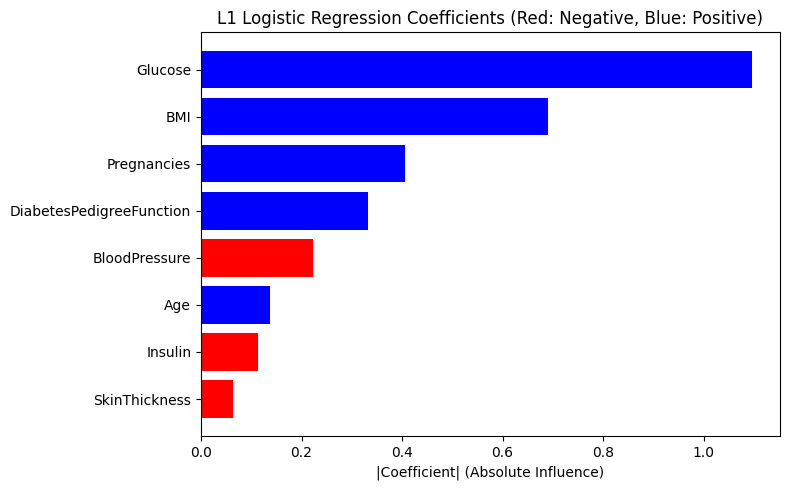

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
abs_coefs = coefs.abs().sort_values(ascending=True)
colors = ['red' if c < 0 else 'blue' for c in coefs[abs_coefs.index]]

plt.barh(abs_coefs.index, abs_coefs.values, color=colors)
plt.title("L1 Logistic Regression Coefficients (Red: Negative, Blue: Positive)")
plt.xlabel("|Coefficient| (Absolute Influence)")
plt.tight_layout()
plt.show()


RFE(5개 선택) : Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction

L1(규제 후 0 제거) : 양 Glucose, BMI, Pregnancies, DiabetesPedigreeFunction, Age / 음 BloodPressure, Insulin, SkinThickness
상위 5개 --> Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction

RFE와 L1의 결과 핵심피처는 동일하다.

In [42]:
rfe_support_series = pd.Series(rfe.support_, index=X_train.columns)


summary = pd.DataFrame({
    "Corr_with_Target": corr,                       # 타깃(Outcome)과의 선형 상관관계 (Filter Method)
    "ANOVA_F": f_scores,                            # ANOVA 클래스(0/1) 구분 능력 (Filter Method)(클수록 구분력 좋음)
    "RFE_Selected(Top5)": rfe_support_series,  # RFE가 최종적으로 선택한 피처 (Wrapper Method)
    "L1_LogReg_Weight": coefs.reindex(X_train.columns)      # L1 규제 로지스틱의 학습 계수 (Embedded Method)
}).sort_values(by=["RFE_Selected(Top5)", "ANOVA_F", "Corr_with_Target"],
                ascending=[False, False, False])

summary


,Corr_with_Target,ANOVA_F,RFE_Selected(Top5),L1_LogReg_Weight
Glucose,0.460108,174.558885,True,1.096938
BMI,0.294390,61.677839,True,0.691110
Pregnancies,0.211340,30.389360,True,0.406472
DiabetesPedigreeFunction,0.173584,20.193870,True,0.331896
BloodPressure,0.049459,1.593915,True,-0.221929
Age,0.218183,32.488992,False,0.136799
Insulin,0.123246,10.025489,False,-0.114077
SkinThickness,0.052094,1.768762,False,-0.063800


### 이상치 탐지

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")

# 핵심 피처만 선택
core_features = ["Glucose", "BMI", "Pregnancies", "DiabetesPedigreeFunction", "BloodPressure"]
X_core = train[core_features].copy()

X_core.head()

,Glucose,BMI,Pregnancies,DiabetesPedigreeFunction,BloodPressure
0,103,24.0,4,0.966,60
1,133,27.0,10,0.245,68
2,112,39.4,4,0.236,78
3,119,45.3,1,0.507,88
4,114,38.1,1,0.289,66


#### Z-Score 기반 이상치 탐지

In [ ]:
from scipy import stats

# Z-Score 계산
# Z = (x - μ) / σ  → 평균(μ)에서 표준편차(σ) 단위로 얼마나 벗어났는지 수치화
z_scores = np.abs(stats.zscore(X_core))

# |Z| > 3 인 행 탐지 (약 0.3%)
threshold = 3
outlier_mask_z = (z_scores > threshold).any(axis=1) # any(axis=1) → 한 행이라도 |Z|>3이면 “이상치”로 표시
outliers_z = X_core[outlier_mask_z]

print("Z-Score 이상치 개수:", outlier_mask_z.sum())
print("이상치 비율:", round(outlier_mask_z.mean() * 100, 2), "%")
outliers_z.head()


Z-Score 이상치 개수: 50
이상치 비율: 7.67 %


,Glucose,BMI,Pregnancies,DiabetesPedigreeFunction,BloodPressure
26,105,0.0,7,0.305,0
50,173,38.4,3,2.137,82
61,0,24.7,1,0.140,48
79,92,24.2,2,1.698,76
85,100,36.6,14,0.412,78


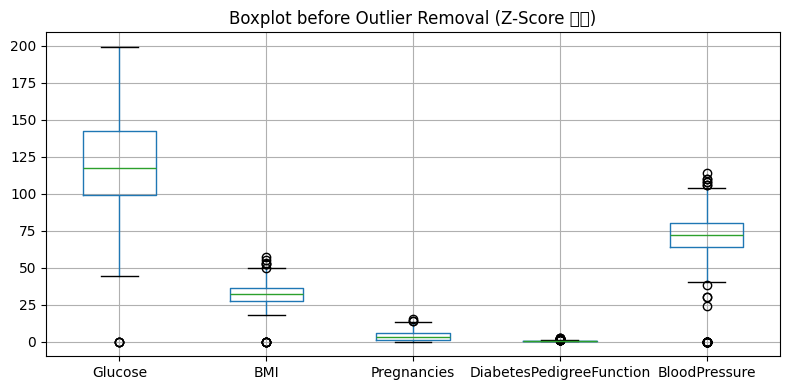

In [54]:
plt.figure(figsize=(8,4))
X_core.boxplot()
plt.title("Boxplot before Outlier Removal (Z-Score 기준)")
plt.tight_layout()
plt.show()


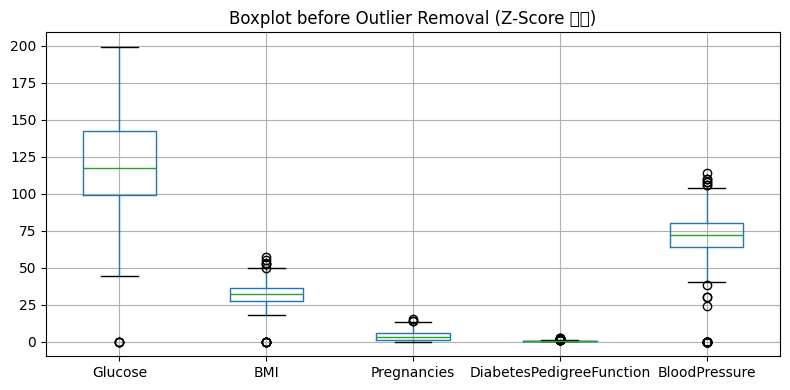

Z-Score 이상치 개수: 50

이상치 비율: 7.67 %

Z-score는 통계적으로만 이상치를 찾기 때문에 실제 유효값인지, 오류값인지는 도메인 지식으로 추가 판단이 필요하다.


#### IQR (사분위 범위) 기반 이상치 탐지

In [55]:
import matplotlib.pyplot as plt

# 각 피처별 사분위수 계산
Q1 = X_core.quantile(0.25)   # 1사분위 (25%)
Q3 = X_core.quantile(0.75)   # 3사분위 (75%)
IQR = Q3 - Q1                # IQR = Q3 - Q1 (중간 50% 범위)

# 상치 조건 계산
# IQR의 1.5배를 기준으로 상/하 경계선을 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 여부 마스크 생성
outlier_mask_iqr = ((X_core < lower_bound) | (X_core > upper_bound)).any(axis=1)

# 이상치 데이터만 추출
outliers_iqr = X_core[outlier_mask_iqr]

print("IQR 이상치 개수:", outlier_mask_iqr.sum())
print("전체 대비 이상치 비율:", round(outlier_mask_iqr.mean() * 100, 2), "%")
outliers_iqr.head()


IQR 이상치 개수: 83
전체 대비 이상치 비율: 12.73 %


,Glucose,BMI,Pregnancies,DiabetesPedigreeFunction,BloodPressure
15,103,39.2,5,0.305,108
26,105,0.0,7,0.305,0
50,173,38.4,3,2.137,82
51,137,48.8,5,0.227,108
61,0,24.7,1,0.140,48


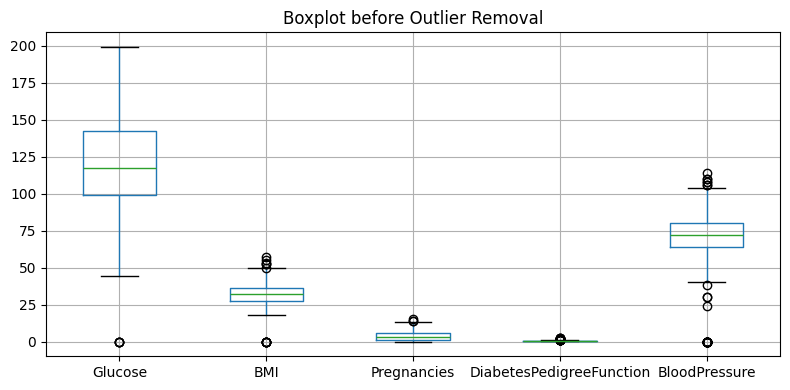

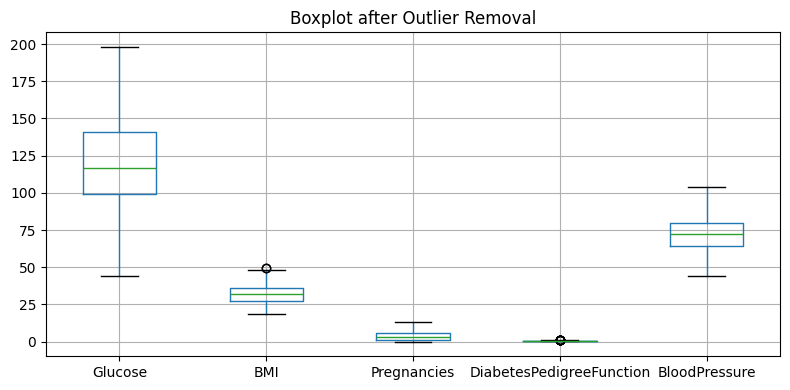

In [57]:
plt.figure(figsize=(8,4))
X_core.boxplot()
plt.title("Boxplot before Outlier Removal")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
X_core[~outlier_mask_iqr].boxplot()
plt.title("Boxplot after Outlier Removal")
plt.tight_layout()
plt.show()


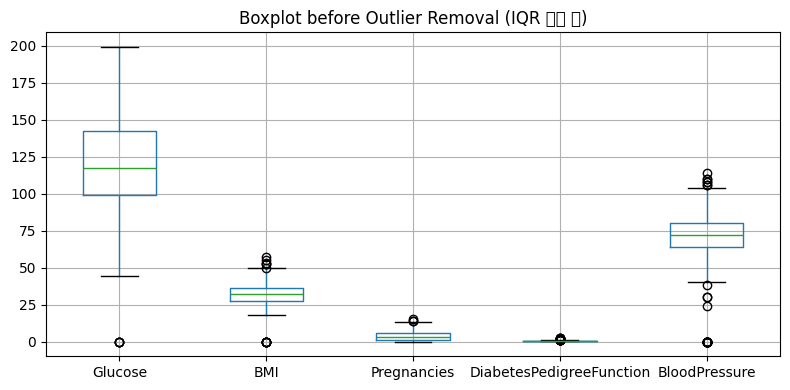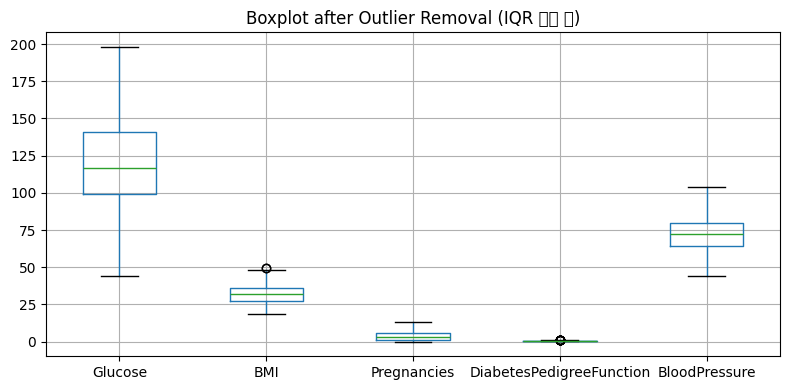

첫 번째 박스플롯: 이상치가 있는 상태 (위아래 점들이 튀어나옴)

두 번째 박스플롯: 이상치 제거 후 분포가 안정화됨

Glucose=0, BMI=0, BloodPressure=0 → 데이터 오류 가능성 높음
DPF>2.0 → 실제 드문 가족력 케이스이지만 임상적으로는 존재 가능
Pregnancies>10 → 드물지만 실제 데이터일 수 있음

#### DBSCAN 기반 이상치 탐지 (밀도 기반)

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# 데이터 표준화
# DBSCAN은 거리 기반 알고리즘이라, 각 변수 스케일이 다르면 왜곡됨
scaler = StandardScaler()   # 평균=0, 표준편차=1로 스케일링
X_scaled = scaler.fit_transform(X_core.drop(columns=["is_outlier_iqr"], errors="ignore"))

# DBSCAN 모델 생성
# eps : 한 점 주위의 반경 (작을수록 세밀하게 탐지)
# min_samples : 한 점이 ‘핵심 포인트’로 인정받기 위한 최소 이웃 수
# metrics : 거리 계산 방식(기본값 euclidean L2거리)
dbscan = DBSCAN(eps=1.5, min_samples=5, metric="euclidean")
labels = dbscan.fit_predict(X_scaled)

# 이상치(label = -1) 추출
outlier_mask_db = (labels == -1)
outliers_db = X_core[outlier_mask_db]

print("DBSCAN 이상치 개수:", np.sum(outlier_mask_db))
print("전체 대비 이상치 비율:", round(np.mean(outlier_mask_db) * 100, 2), "%")

outliers_db.head(10)


DBSCAN 이상치 개수: 27
전체 대비 이상치 비율: 4.14 %


,Glucose,BMI,Pregnancies,DiabetesPedigreeFunction,BloodPressure
26,105,0.0,7,0.305,0
50,173,38.4,3,2.137,82
61,0,24.7,1,0.140,48
130,180,42.0,0,1.893,66
135,80,0.0,3,0.174,0
151,115,0.0,10,0.261,0
161,158,42.3,13,0.257,114
235,189,28.5,4,0.680,110
255,119,19.6,2,0.832,0
275,74,0.0,2,0.102,0


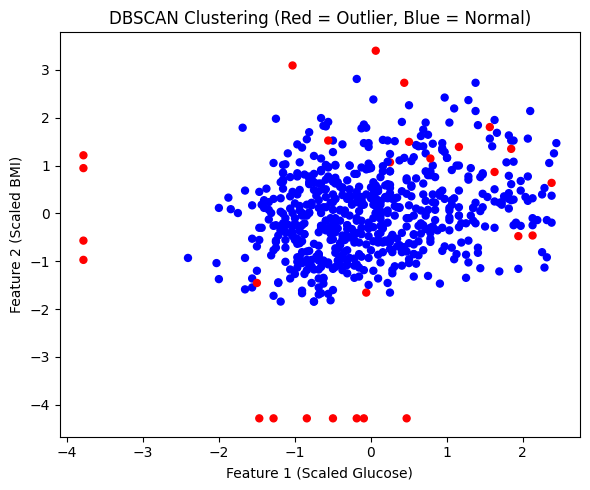

In [ ]:
colors = np.where(labels == -1, 'red', 'blue')

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=colors, s=25)
plt.title("DBSCAN Clustering (Red = Outlier, Blue = Normal)")
plt.xlabel("Feature 1 (Scaled Glucose)")
plt.ylabel("Feature 2 (Scaled BMI)")
plt.tight_layout()
plt.show()


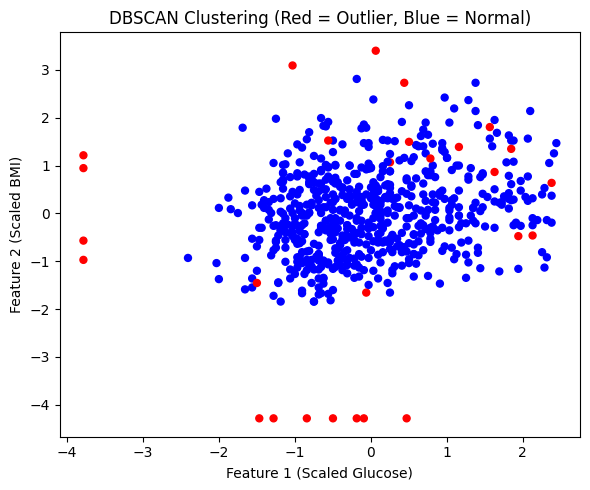

X축: Scaled Glucose (표준화된 혈당 값)

Y축: Scaled BMI (표준화된 체질량 지수)

점 색깔: DBSCAN의 군집(label)

label = -1 → 이상치 (Outlier, Red)
label ≠ -1 → 정상 군집 (Inlier, Blue)

즉, 파란색 점이 정상, 빨간색 점이 이상치이다.
파란점은 대부분 중심부에 밀집해 이ㅆ으며, 빨간색은 주로 외곽에 고립되 있다.

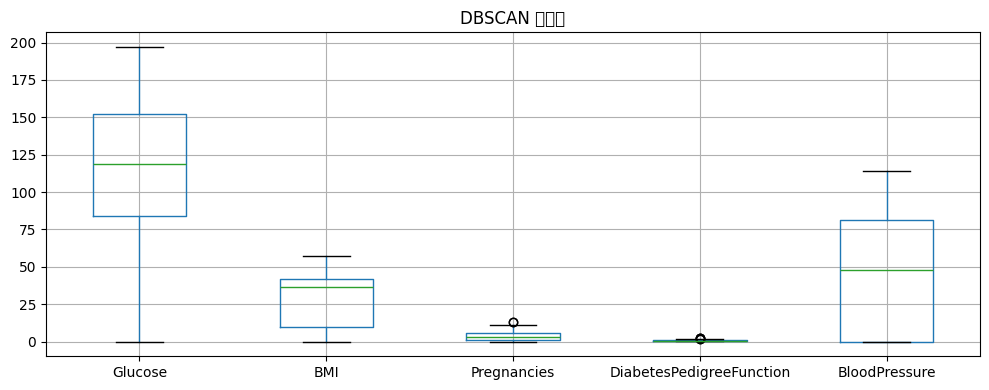

In [66]:
plt.figure(figsize=(10,4))
outliers_db.boxplot()
plt.title("DBSCAN 이상치")
plt.tight_layout()
plt.show()


In [60]:
summary_outliers = pd.DataFrame({
    "Method": ["Z-Score", "IQR", "DBSCAN"],
    "Outlier_Count": [outlier_mask_z.sum(), outlier_mask_iqr.sum(), np.sum(outlier_mask_db)],
    "Outlier_Ratio(%)": [
        round(outlier_mask_z.mean() * 100, 2),
        round(outlier_mask_iqr.mean() * 100, 2),
        round(np.mean(outlier_mask_db) * 100, 2)
    ]
})
summary_outliers


,Method,Outlier_Count,Outlier_Ratio(%)
0,Z-Score,50,7.67
1,IQR,83,12.73
2,DBSCAN,27,4.14


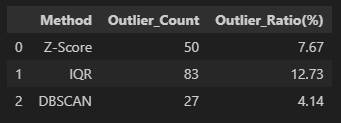

Z-Score : 정규성 가정 하에 볼 때 비교적 안정적인 데이터지만, 극단값이 존재한다.
IQR : 중앙값 중심의 분포 기반 방식이라 꼬리가 있는 경우 높게 나올 수 있다.
DBSCAN : 데이터가 전반적으로 한두 개의 주요 군집에 밀집돼 있고, 완전히 벗어난 점이 적다.